the QSAR data set from this https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity. It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards https://en.wikipedia.org/wiki/Daphnia_magna

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt
import pandas as pd

In [36]:
class NeuralNetwork():
    
    def __init__(self,n_inputs,m_hiddens_list,n_outputs):
        self.n_inputs= n_inputs
        self.m_hiddens_list=m_hiddens_list
        self.n_outputs=n_outputs
        
        self.all_gradients,self.Gs=self.make_weights()
        self.all_weights,self.Ws=self.make_weights()
        
        self.Ws=self.initialize_weights()
        
        self.stand_params=None
        
        self.n_layers=len(m_hiddens_list)+1
        self.error_trace=None
      
        
       
    def __repr__(self):
        
        return f'{type(self).__name__}({self.n_inputs}, {self.m_hiddens_list}, {self.n_outputs})'
 
    def make_weights(self):

        n_weights=0
        for i in range(len(self.m_hiddens_list)):
            if i==0:
                n_v=(1+self.n_inputs)*(self.m_hiddens_list[i])
                n_weights+=n_v
            else:
                n_v=((self.m_hiddens_list[i-1] + 1)*(self.m_hiddens_list[i]))
                n_weights+=n_v
        n_v=(1+(self.m_hiddens_list[-1]))*(self.n_outputs)
        n_weights+=n_v

        all_weights = np.zeros(n_weights)

        ws=[]
        for i in range(len(self.m_hiddens_list)):
            if i==0:
                t1=(1+self.n_inputs)*(self.m_hiddens_list[i])
                ws.append(all_weights[:t1].reshape(1+self.n_inputs,self.m_hiddens_list[i]))
            else:
                t2=(self.m_hiddens_list[i-1] + 1)*(self.m_hiddens_list[i])
                ws.append((all_weights[t1:t2+t1]).reshape(self.m_hiddens_list[i-1] + 1,self.m_hiddens_list[i]))
                t1=t2+t1
        t3=(1+self.m_hiddens_list[-1])*(self.n_outputs)
        t3=len(all_weights)-t3
        ws.append(all_weights[t3:].reshape(1+self.m_hiddens_list[-1],self.n_outputs))   
       
        return all_weights,ws
    
    def initialize_weights(self):
    
    
        for i in range(len(self.m_hiddens_list)):
            if i==0:
                self.Ws[i][:]=np.random.uniform(-1, 1, size=(1 + self.n_inputs, self.m_hiddens_list[i])) / np.sqrt(self.n_inputs + 1)
            else:
                self.Ws[i][:]=np.random.uniform(-1, 1, size=(self.m_hiddens_list[i-1]+1, self.m_hiddens_list[i])) / np.sqrt(self.m_hiddens_list[i-1] + 1)
        self.Ws[-1][:]= np.random.uniform(-1, 1, size=(self.m_hiddens_list[-1]+1, self.n_outputs)) / np.sqrt(self.m_hiddens_list[-1] + 1)
    
        return self.Ws
    def train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):
        
    
        optimizer = opt.Optimizers(self.all_weights)
        
        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X, self.stand_params)
        Tst = self.standardize_T(T, self.stand_params)
        
        if method == 'sgd':
            self.error_trace = optimizer.sgd(self.mse, self.gradient_f, [Xst,Tst], n_epochs, learning_rate,error_convert_f=self.error_convert)
        elif method == 'adam':
            self.error_trace = optimizer.adam(self.mse, self.gradient_f, [Xst,Tst], n_epochs, learning_rate,error_convert_f=self.error_convert)
        elif method == 'scg':
            self.error_trace = optimizer.scg(self.mse, self.gradient_f, [Xst,Tst], n_epochs, learning_rate,error_convert_f=self.error_convert)
 
        
    def calc_standardize_parameters(self,X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds,
            'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self,X, stand_params):
        return (X - stand_params['Xmeans']) / stand_params['Xstds']


    def unstandardize_X(self,Xst, stand_params):
        return Xst * stand_params['Xstds'] + stand_params['Xmeans']


    def standardize_T(self,T, stand_params):
        return (T - stand_params['Tmeans']) / stand_params['Tstds']


    def unstandardize_T(self,Tst, stand_params):
        return Tst * stand_params['Tstds'] + stand_params['Tmeans']    
        
    def mse(self,Xst,Tst):
        Yst = self.forward(Xst)
        return  np.mean((Tst - Yst[-1])**2)
    
    def forward(self,Xst):
        layerop=[]
        for i in range(len(self.Ws)-1):
            if i==0:
                T = np.tanh(self.add_ones(Xst)@self.Ws[i])
                layerop.append(T)
            else:
                T=np.tanh(self.add_ones(T)@self.Ws[i])
                layerop.append(T)
        T=self.add_ones(T)@self.Ws[-1]

        layerop.append(T)
        return layerop
   
    def gradient_f(self,Xst,Tst):
        Y = self.forward(Xst)
        self.n_outputs = Tst.shape[1]

        self.n_samples = Xst.shape[0]
        delta = -2*(Tst - Y[-1]) /  (self.n_samples * self.n_outputs)
        self.Gs[-1][:] = self.add_ones(Y[-2]).T @ delta
        for i in reversed(range(len(self.Ws)-1)):
            if i==0:
                delta = (delta @ self.Ws[i+1][1:, :].T)*(1 - Y[i] ** 2) 
                self.Gs[i][:] = self.add_ones(Xst).T @ delta
            else:
                delta=(delta @ self.Ws[i+1][1:, :].T) * (1 - Y[i] ** 2)
                self.Gs[i][:] = self.add_ones(Y[i-1]).T @ delta
        return self.all_gradients
        
    def add_ones(self,X):
        return np.insert(X, 0, 1, axis=1)
    def get_error_trace(self):
        return self.error_trace
     
    def use(self, X, return_hidden_layer_outputs=False):
        
        Xst = self.standardize_X(X, self.stand_params)
        Y = self.forward(Xst)
        Y_last=self.unstandardize_T(Y[-1], self.stand_params)
        if return_hidden_layer_outputs==False:
            return Y_last
        if return_hidden_layer_outputs==True:
            return Y_last,Y[:-1]
    
    def error_convert(self,err):
        
        if self.n_outputs == 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:
            return np.sqrt(err)
    def rmse(self):
        
        return np.sqrt(np.mean((Tst - Yst[-1])**2))

In [37]:
np.random.seed(123)
nnet = NeuralNetwork(1, [3], 2)  # 2 outputs
nnet

NeuralNetwork(1, [3], 2)

In [38]:
nnet.all_weights

array([ 0.27784939, -0.30244465, -0.38629038,  0.07257004,  0.31037599,
       -0.10874389,  0.4807642 ,  0.18482974, -0.0190681 , -0.10788248,
       -0.15682198,  0.22904971, -0.06142776, -0.4403221 ])

In [39]:
nnet.Ws

[array([[ 0.27784939, -0.30244465, -0.38629038],
        [ 0.07257004,  0.31037599, -0.10874389]]),
 array([[ 0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248],
        [-0.15682198,  0.22904971],
        [-0.06142776, -0.4403221 ]])]

In [40]:
nnet.Gs

[array([[0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [41]:
nnet.all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
X = np.linspace(-1, 1, 4).reshape(-1, 1)
X

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ]])

In [43]:
T = np.hstack((X ** 2, (X - 2) ** 3))
T

array([[  1.        , -27.        ],
       [  0.11111111, -12.7037037 ],
       [  0.11111111,  -4.62962963],
       [  1.        ,  -1.        ]])

In [44]:
nnet.train(X, T, 5, 0.01, method='adam')

Adam: Epoch 1 Error=1.04625
Adam: Epoch 2 Error=1.03472
Adam: Epoch 3 Error=1.02343
Adam: Epoch 4 Error=1.01223
Adam: Epoch 5 Error=1.00111


In [45]:
nnet.Gs

[array([[-0.05090467, -0.0454069 , -0.10866125],
        [ 0.11280118, -0.1552129 ,  0.33065424]]),
 array([[ 0.45676396,  0.18176547],
        [ 0.13959465,  0.03152188],
        [-0.13673716, -0.29306245],
        [-0.14982828,  0.05032327]])]

In [46]:
nnet.all_weights

array([ 0.32805609, -0.25283707, -0.33680913,  0.02237977,  0.36049589,
       -0.15868899,  0.43097923,  0.13534218, -0.06903616, -0.15739471,
       -0.10716161,  0.27902101, -0.01180826, -0.44858975])

In [47]:
nnet.stand_params

{'Xmeans': array([-5.55111512e-17]),
 'Xstds': array([0.74535599]),
 'Tmeans': array([  0.55555556, -11.33333333]),
 'Tstds': array([0.44444444, 9.98799004])}

In [48]:
nnet.Ws

[array([[ 0.32805609, -0.25283707, -0.33680913],
        [ 0.02237977,  0.36049589, -0.15868899]]),
 array([[ 0.43097923,  0.13534218],
        [-0.06903616, -0.15739471],
        [-0.10716161,  0.27902101],
        [-0.01180826, -0.44858975]])]

In [49]:
nnet.get_error_trace()

[1.046252745686667,
 1.0347196138595187,
 1.0234280115224064,
 1.0122313682158668,
 1.0011130457971062]

In [50]:
nnet.use(X)

array([[  0.76872931, -11.63174677],
       [  0.75768845, -10.3937065 ],
       [  0.74348724,  -9.01615633],
       [  0.72838516,  -7.64787959]])

In [51]:
Y, Zs = nnet.use(X, return_hidden_layer_outputs=True)
Y, Zs  # Zs is list of hidden layer output matrices


(array([[  0.76872931, -11.63174677],
        [  0.75768845, -10.3937065 ],
        [  0.74348724,  -9.01615633],
        [  0.72838516,  -7.64787959]]),
 [array([[ 0.2895092 , -0.62702167, -0.12327529],
         [ 0.30774044, -0.39191092, -0.25975089],
         [ 0.32574848, -0.09136292, -0.38658353],
         [ 0.34352322,  0.22680528, -0.50030489]])])

In [52]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]
    #print("Xtrain",Xtrain.shape)
    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)
    
    def rmse(Y, T):
    
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    #Y= nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
  
    return nnet

sgd: Epoch 400 Error=0.22829
sgd: Epoch 800 Error=0.18081
sgd: Epoch 1200 Error=0.14822
sgd: Epoch 1600 Error=0.13567
sgd: Epoch 2000 Error=0.13215
sgd: Epoch 2400 Error=0.13068
sgd: Epoch 2800 Error=0.12974
sgd: Epoch 3200 Error=0.12911
sgd: Epoch 3600 Error=0.12876
sgd: Epoch 4000 Error=0.12851
Method: sgd, RMSE: Train 0.13 Test 0.29


NeuralNetwork(1, [50, 20, 20], 1)

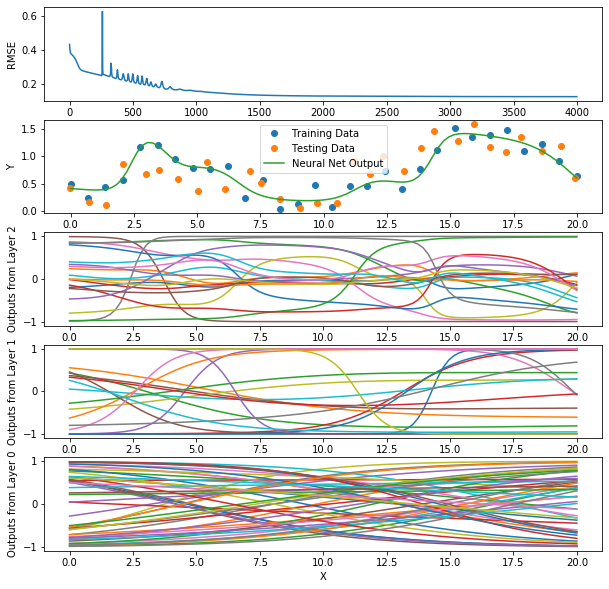

In [53]:
 run('sgd', 4000, 0.1)

Adam: Epoch 200 Error=0.18749
Adam: Epoch 400 Error=0.12221
Adam: Epoch 600 Error=0.09956
Adam: Epoch 800 Error=0.08557
Adam: Epoch 1000 Error=0.08227
Adam: Epoch 1200 Error=0.08200
Adam: Epoch 1400 Error=0.08559
Adam: Epoch 1600 Error=0.07989
Adam: Epoch 1800 Error=0.07668
Adam: Epoch 2000 Error=0.07465
Method: adam, RMSE: Train 0.07 Test 0.26


NeuralNetwork(1, [50, 20, 20], 1)

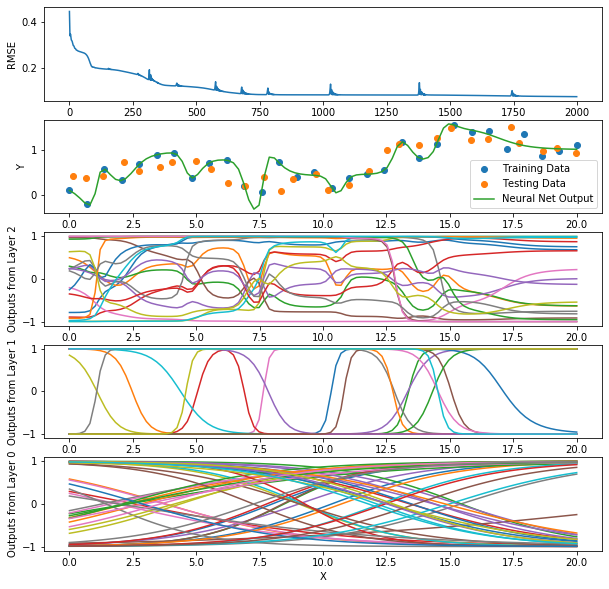

In [54]:
run('adam', 2000, 0.01)

SCG: Epoch 200 Error=0.14623
SCG: Epoch 400 Error=0.08949
SCG: Epoch 600 Error=0.06921
SCG: Epoch 800 Error=0.05943
SCG: Epoch 1000 Error=0.01971
SCG: Epoch 1200 Error=0.00875
SCG: Epoch 1400 Error=0.00049
SCG: Epoch 1600 Error=0.00021
SCG: Epoch 1800 Error=0.00008
SCG: Epoch 2000 Error=0.00002
Method: scg, RMSE: Train 0.00 Test 0.32


NeuralNetwork(1, [50, 20, 20], 1)

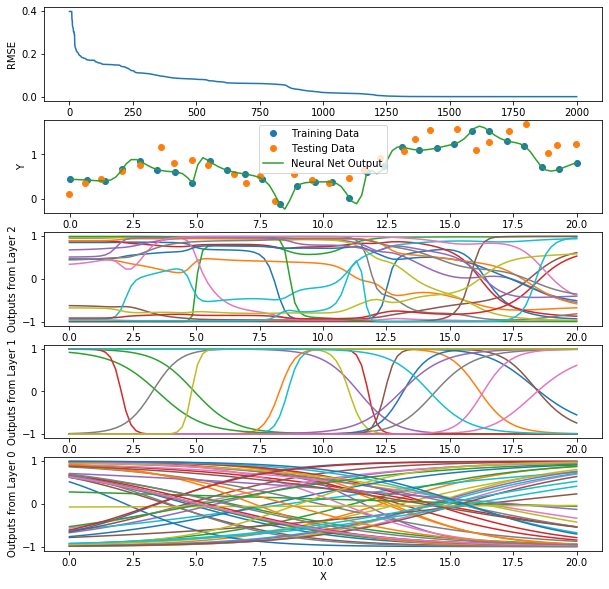

In [55]:
run('scg', 2000)

In [56]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gaddam-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[10]


--- 

In [57]:
data=pd.read_csv('qsar_aquatic_toxicity.csv', sep=';',header=None)
data

0       1  2      3      4      5  6  7      8
0     0.00   0.000  0  2.419  1.225  0.667  0  0  3.740
1     0.00   0.000  0  2.638  1.401  0.632  0  0  4.330
2     9.23  11.000  0  5.799  2.930  0.486  0  0  7.019
3     9.23  11.000  0  5.453  2.887  0.495  0  0  6.723
4     9.23  11.000  0  4.068  2.758  0.695  0  0  5.979
..     ...     ... ..    ...    ...    ... .. ..    ...
541  24.06  35.776  2  3.326  2.837  0.849  2  0  4.651
542   9.23  11.000  0  3.275  2.727  0.874  0  0  3.953
543   0.00   0.000  0  5.165  3.111  0.732  0  0  6.219
544  13.14   9.507  0  2.859  2.614  0.827  0  0  4.995
545   0.00   0.000  0  2.255  1.800  0.917  0  0  2.480

[546 rows x 9 columns]

In [58]:
data=data.values

In [59]:
np.random.shuffle(data)

In [60]:
data

array([[  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   4.98 ],
       [ 50.94 ,  76.132,   1.   , ...,   3.   ,   0.   ,   4.01 ],
       [ 86.34 , 105.331,   1.   , ...,   5.   ,   0.   ,   4.168],
       ...,
       [ 29.46 ,  53.683,   1.   , ...,   0.   ,   0.   ,   6.109],
       [ 12.53 ,  11.   ,   0.   , ...,   0.   ,   0.   ,   6.508],
       [ 45.82 ,  50.747,   0.   , ...,   1.   ,   0.   ,   4.66 ]])

In [61]:
data_Train=data[:500]
data_Test=data[500:]

In [62]:
Ttrain = data_Train[:, -1] # for last column
Xtrain = data_Train[:, :-1] # for all but last column

In [63]:
Ttrain=Ttrain.reshape(-1,1)
Ttrain.shape

(500, 1)

In [64]:
Xtrain.shape

(500, 8)

In [65]:
Ttest = data_Test[:, -1] # for last column
Xtest = data_Test[:, :-1] # for all but last column

In [66]:
Ttest=Ttest.reshape(-1,1)
Ttest.shape

(46, 1)

In [67]:
Xtest.shape

(46, 8)

# Experiments With SGD 

# Experiment 1A

In [97]:
n_hiddens_list=[10,10]
n_epochs=1000
learning_rate=0.01
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='sgd')

sgd: Epoch 100 Error=1.41591
sgd: Epoch 200 Error=1.27578
sgd: Epoch 300 Error=1.23257
sgd: Epoch 400 Error=1.20612
sgd: Epoch 500 Error=1.18818
sgd: Epoch 600 Error=1.17582
sgd: Epoch 700 Error=1.16713
sgd: Epoch 800 Error=1.16086
sgd: Epoch 900 Error=1.15617
sgd: Epoch 1000 Error=1.15243


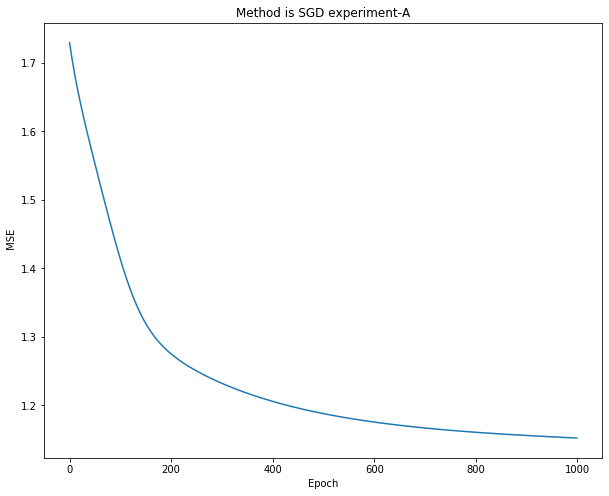

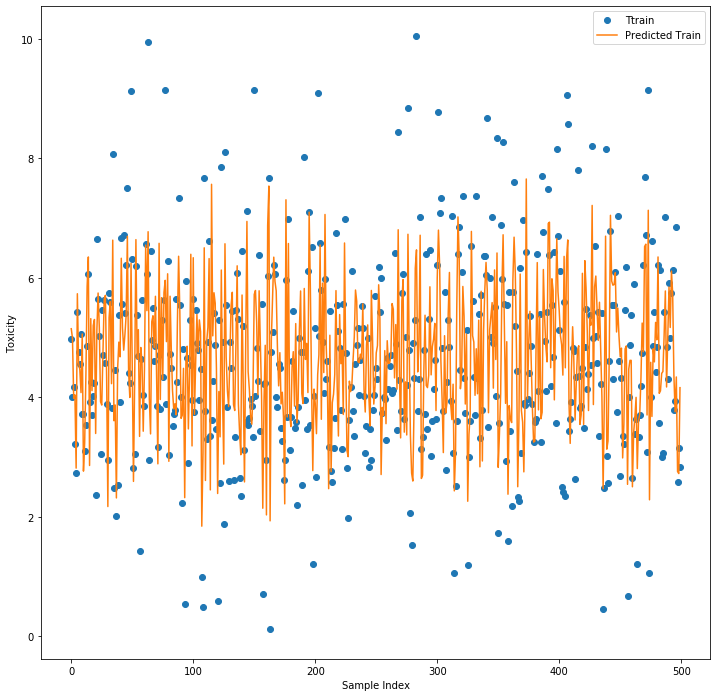

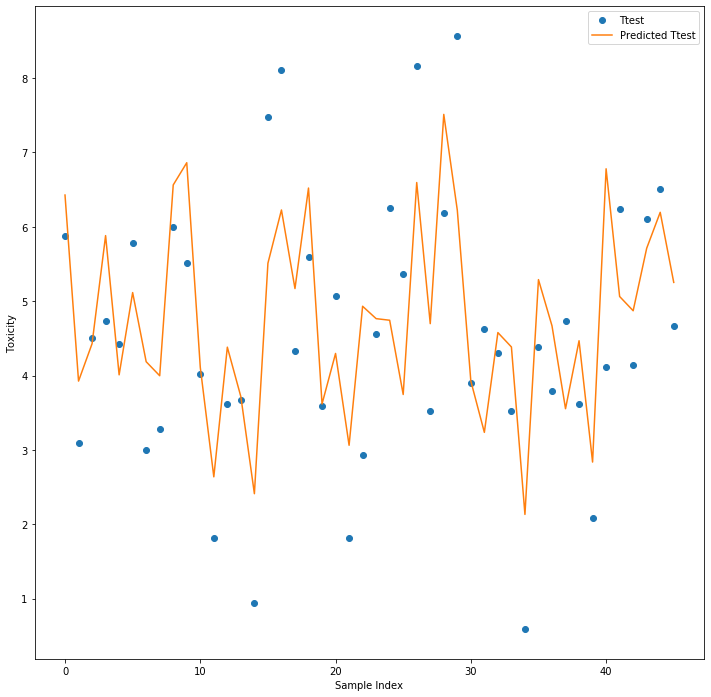

In [98]:
plt.figure(figsize=(10, 8))
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SGD experiment-A')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiment 1B

In [70]:
n_hiddens_list=[10,20,30]
n_epochs=20000
learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='sgd')

sgd: Epoch 2000 Error=0.87397
sgd: Epoch 4000 Error=0.70818
sgd: Epoch 6000 Error=0.60296
sgd: Epoch 8000 Error=0.49513
sgd: Epoch 10000 Error=0.42479
sgd: Epoch 12000 Error=0.36364
sgd: Epoch 14000 Error=0.31674
sgd: Epoch 16000 Error=0.28843
sgd: Epoch 18000 Error=0.27677
sgd: Epoch 20000 Error=0.25851


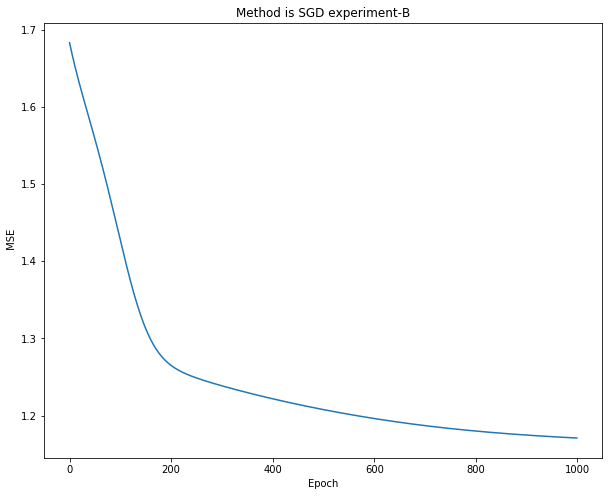

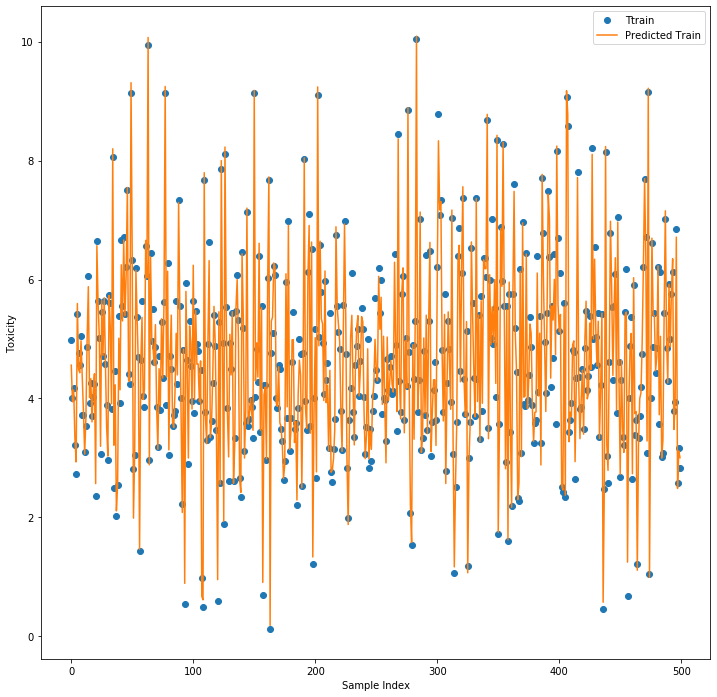

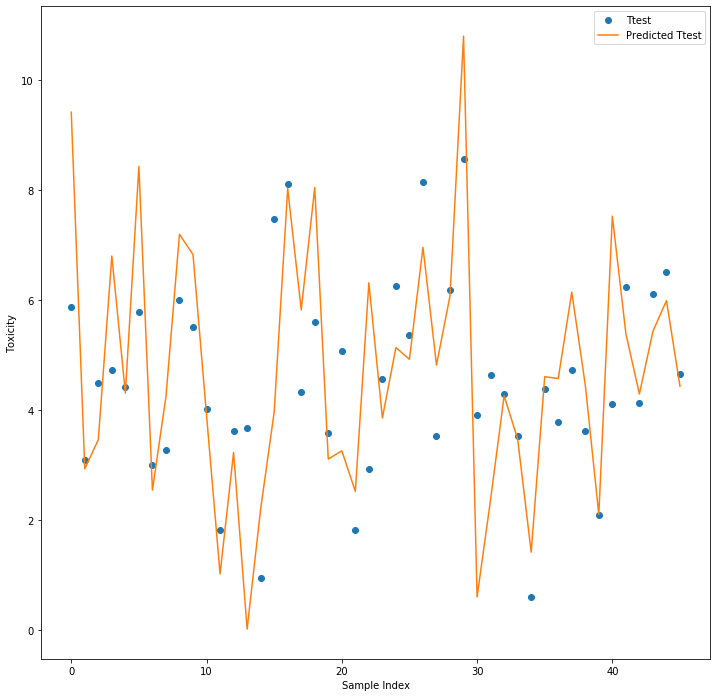

In [71]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SGD experiment-B')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiment 1C

In [72]:
n_hiddens_list=[10,20,30]
n_epochs=20000
learning_rate=0.001
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='sgd')


sgd: Epoch 2000 Error=1.32816
sgd: Epoch 4000 Error=1.23890
sgd: Epoch 6000 Error=1.18838
sgd: Epoch 8000 Error=1.16634
sgd: Epoch 10000 Error=1.15700
sgd: Epoch 12000 Error=1.15015
sgd: Epoch 14000 Error=1.14328
sgd: Epoch 16000 Error=1.13558
sgd: Epoch 18000 Error=1.12640
sgd: Epoch 20000 Error=1.11528


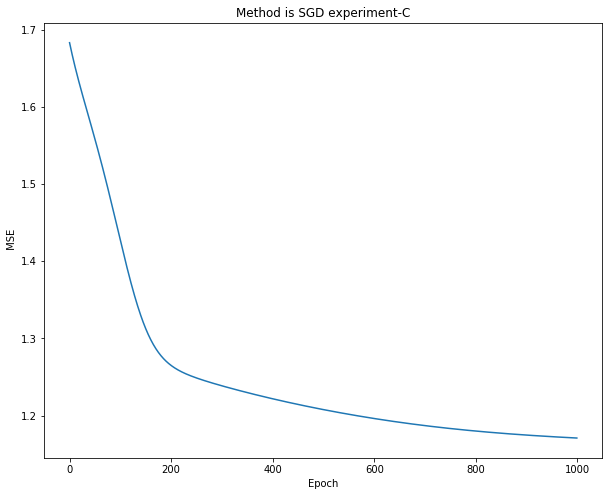

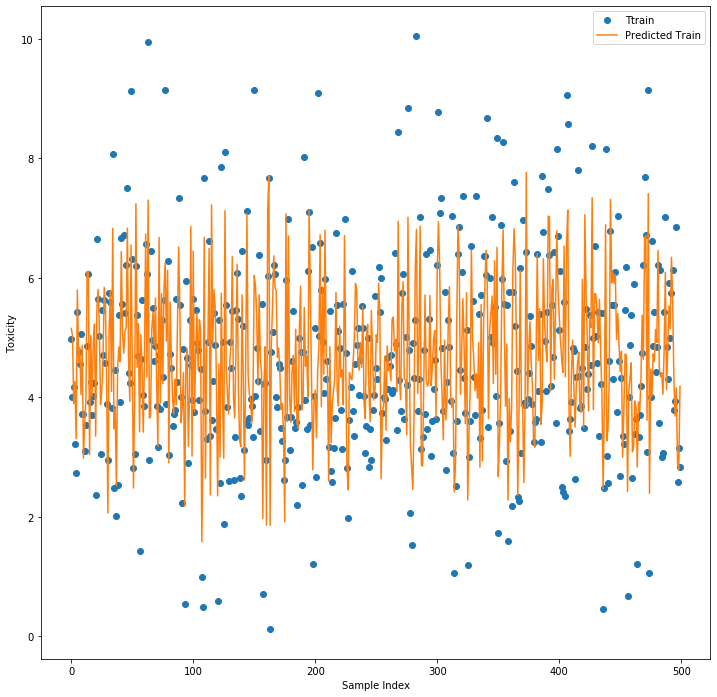

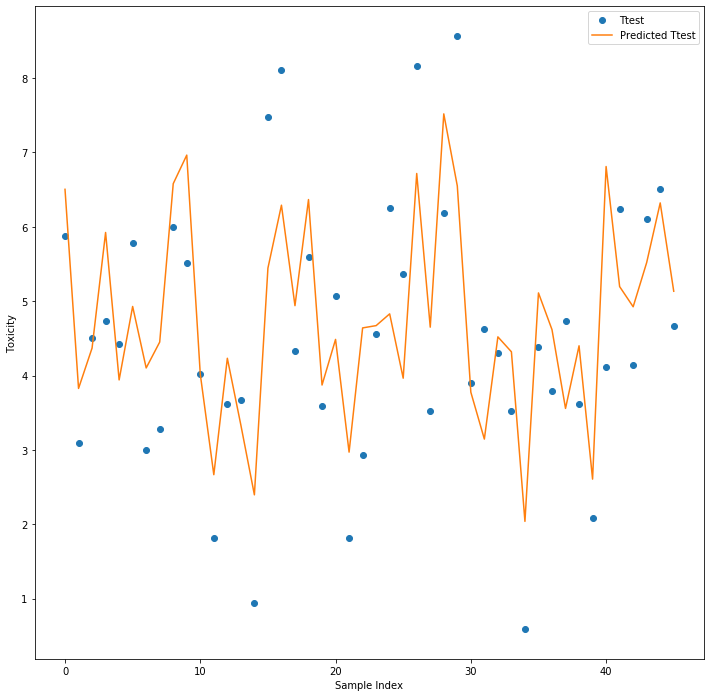

In [73]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SGD experiment-C')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiment 1D

In [74]:
n_hiddens_list=[30,30]
n_epochs=40000
learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='sgd')

sgd: Epoch 4000 Error=0.61216
sgd: Epoch 8000 Error=0.42485
sgd: Epoch 12000 Error=0.34398
sgd: Epoch 16000 Error=0.30492
sgd: Epoch 20000 Error=0.27059
sgd: Epoch 24000 Error=0.23666
sgd: Epoch 28000 Error=0.22548
sgd: Epoch 32000 Error=0.21483
sgd: Epoch 36000 Error=0.20234
sgd: Epoch 40000 Error=0.19318


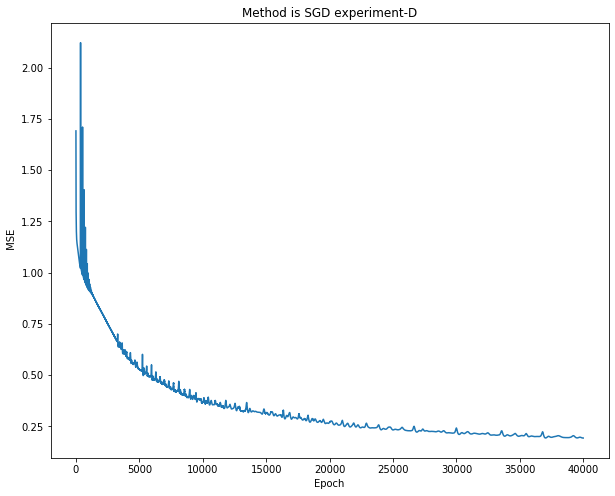

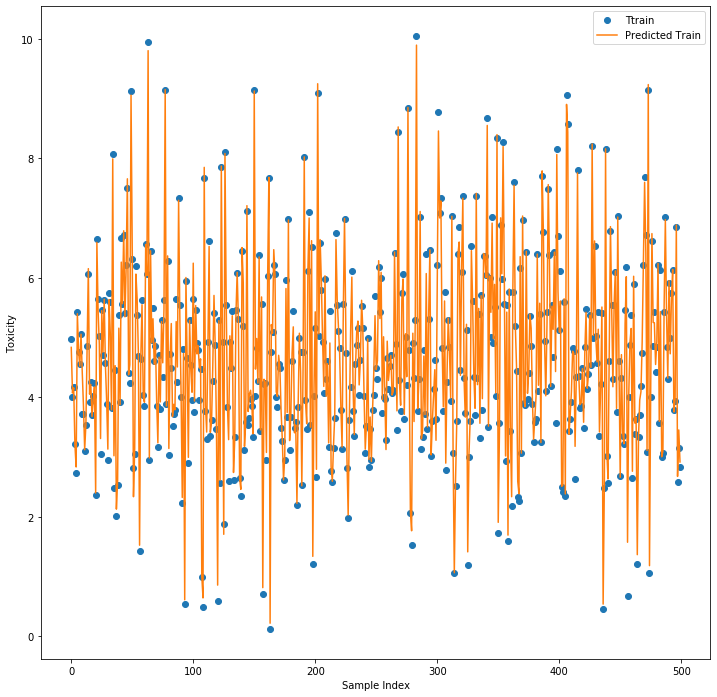

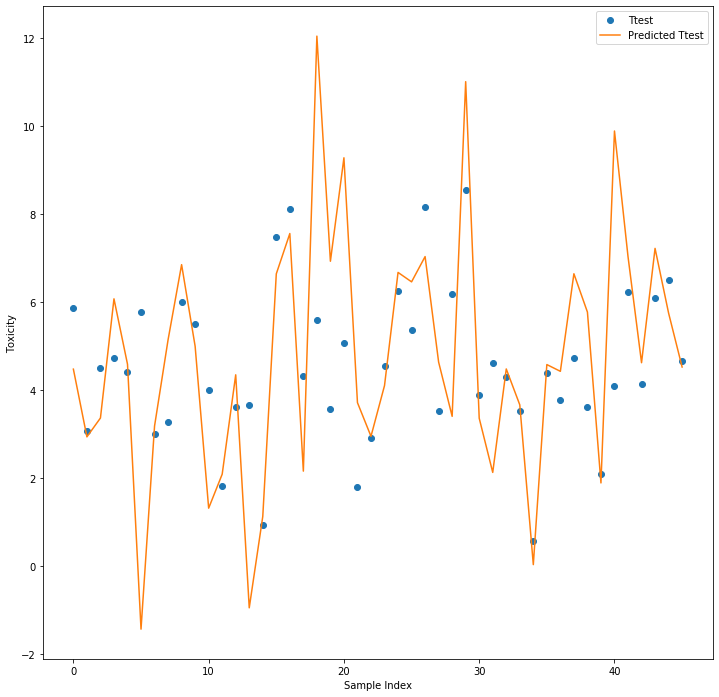

In [75]:
plt.figure(figsize=(10, 8))
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SGD experiment-D')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiment 1E

In [76]:
n_hiddens_list=[50,50]
n_epochs=40000
learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='sgd')

sgd: Epoch 4000 Error=0.56908
sgd: Epoch 8000 Error=0.37861
sgd: Epoch 12000 Error=0.29063
sgd: Epoch 16000 Error=0.25324
sgd: Epoch 20000 Error=0.22949
sgd: Epoch 24000 Error=0.21654
sgd: Epoch 28000 Error=0.20459
sgd: Epoch 32000 Error=0.20165
sgd: Epoch 36000 Error=0.19249
sgd: Epoch 40000 Error=0.20279


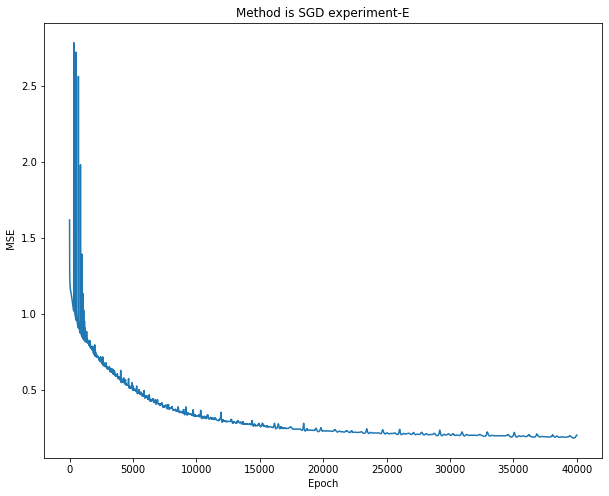

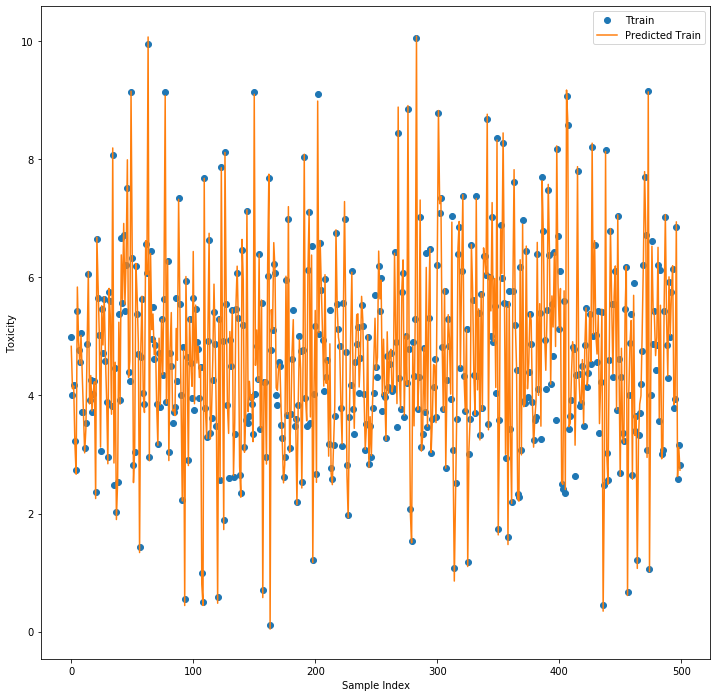

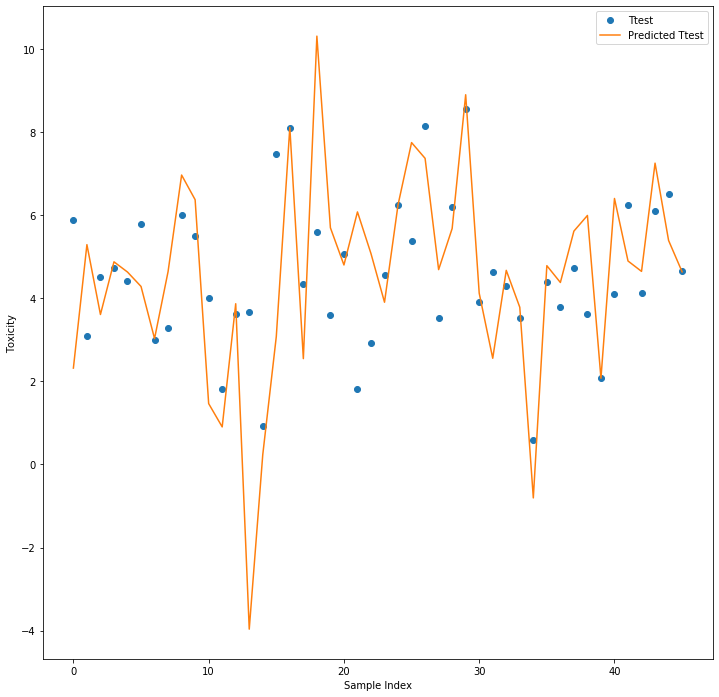

In [77]:
plt.figure(figsize=(10, 8))
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SGD experiment-E')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments With ADAM

# Experiments 2A

In [78]:
n_hiddens_list=[20,20]
n_epochs=2000
learning_rate=0.01
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')

Adam: Epoch 200 Error=0.74035
Adam: Epoch 400 Error=0.49574
Adam: Epoch 600 Error=0.38915
Adam: Epoch 800 Error=0.34191
Adam: Epoch 1000 Error=0.30490
Adam: Epoch 1200 Error=0.28213
Adam: Epoch 1400 Error=0.25489
Adam: Epoch 1600 Error=0.24473
Adam: Epoch 1800 Error=0.23569
Adam: Epoch 2000 Error=0.22879


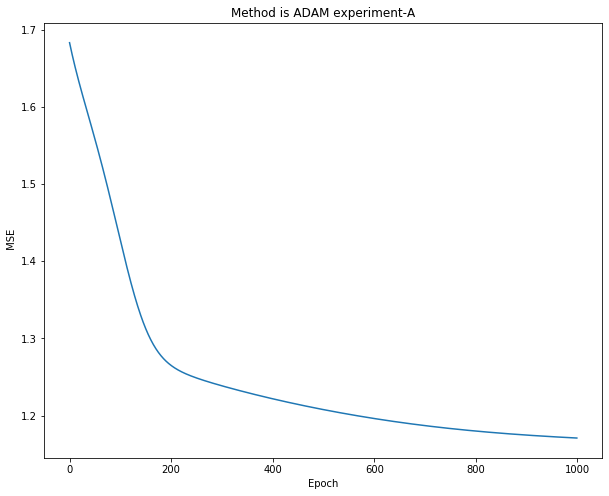

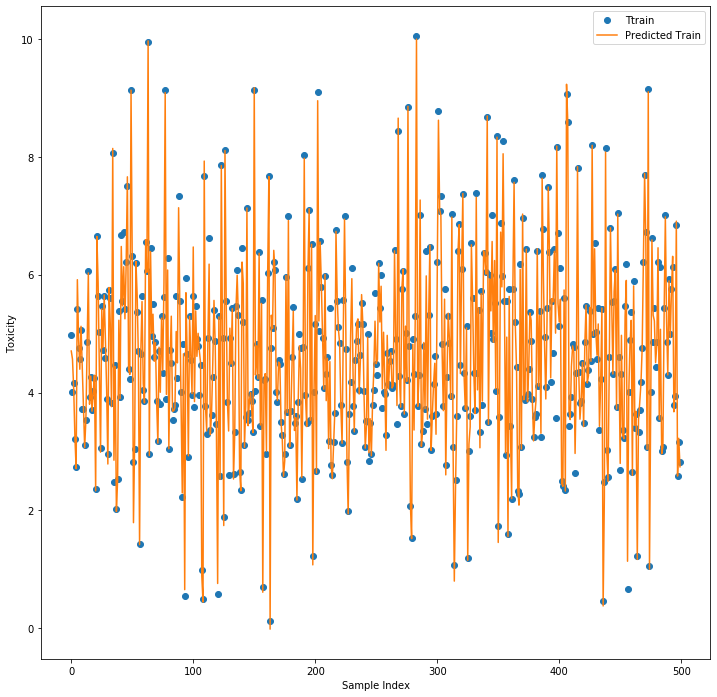

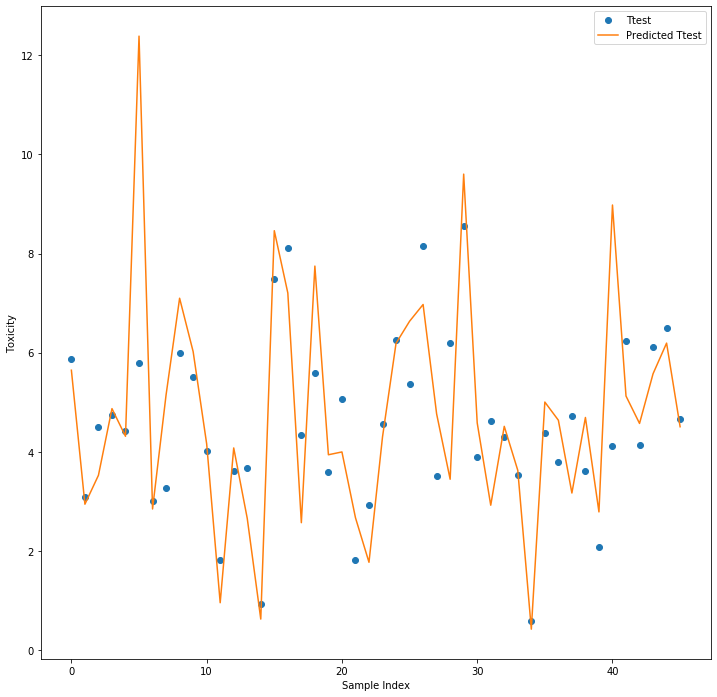

In [79]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is ADAM experiment-A')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 2B

In [80]:
n_hiddens_list=[10,10]
n_epochs=1000
learning_rate=0.01
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')

Adam: Epoch 100 Error=1.04598
Adam: Epoch 200 Error=0.87890
Adam: Epoch 300 Error=0.75923
Adam: Epoch 400 Error=0.70377
Adam: Epoch 500 Error=0.65920
Adam: Epoch 600 Error=0.62166
Adam: Epoch 700 Error=0.60179
Adam: Epoch 800 Error=0.58277
Adam: Epoch 900 Error=0.57161
Adam: Epoch 1000 Error=0.56490


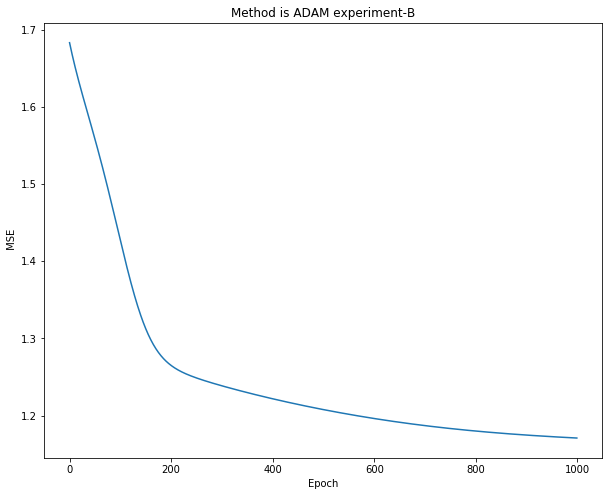

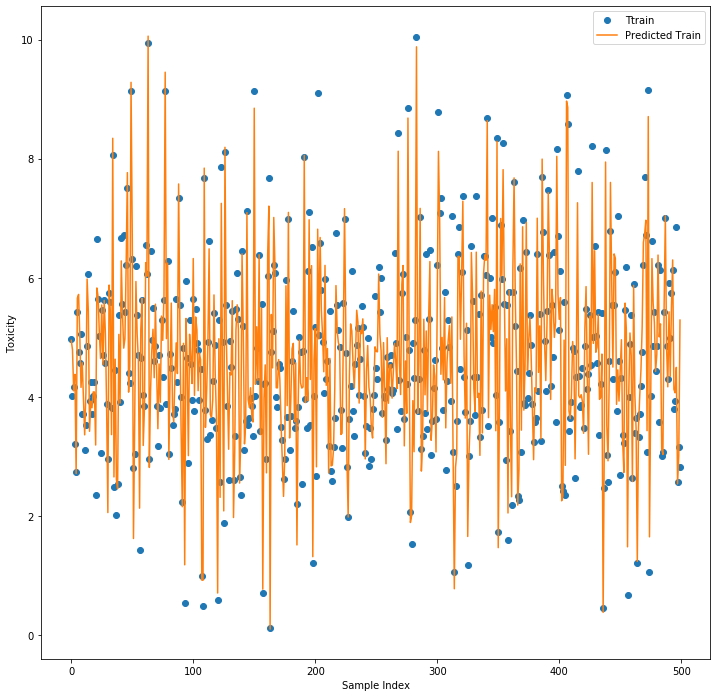

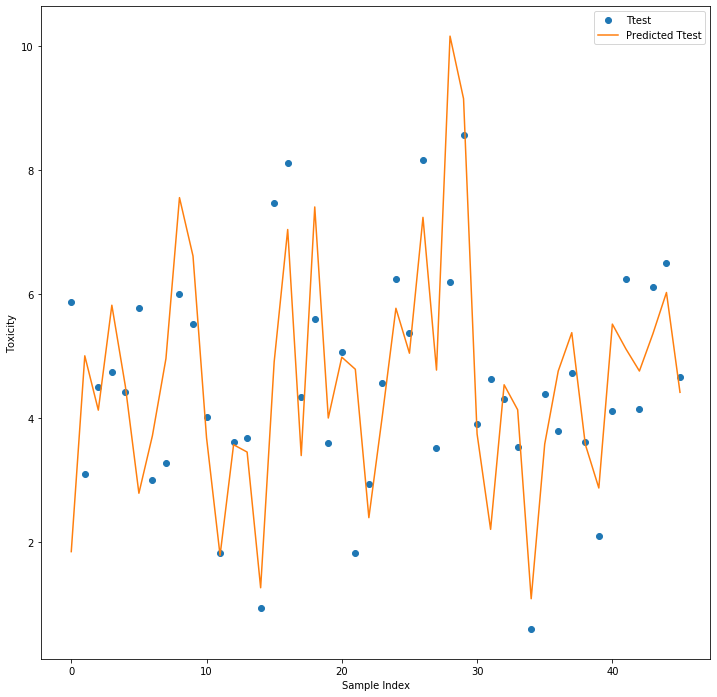

In [81]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is ADAM experiment-B')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 2C

In [82]:
n_hiddens_list=[10,20,30]
n_epochs=20000
learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')

Adam: Epoch 2000 Error=0.21493
Adam: Epoch 4000 Error=0.43589
Adam: Epoch 6000 Error=0.18154
Adam: Epoch 8000 Error=0.25406
Adam: Epoch 10000 Error=0.31961
Adam: Epoch 12000 Error=0.35327
Adam: Epoch 14000 Error=0.76850
Adam: Epoch 16000 Error=0.82793
Adam: Epoch 18000 Error=0.90670
Adam: Epoch 20000 Error=0.98482


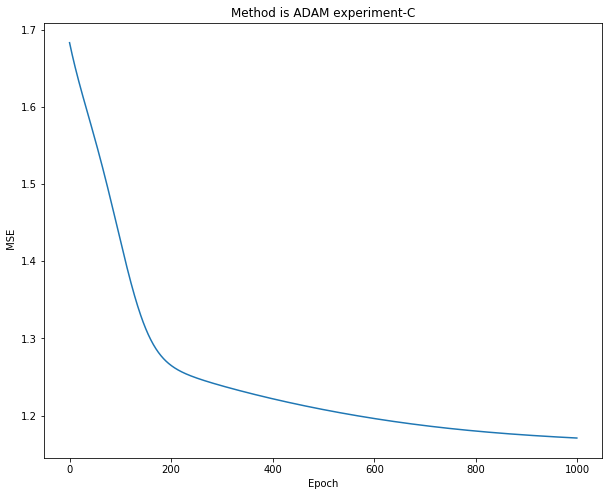

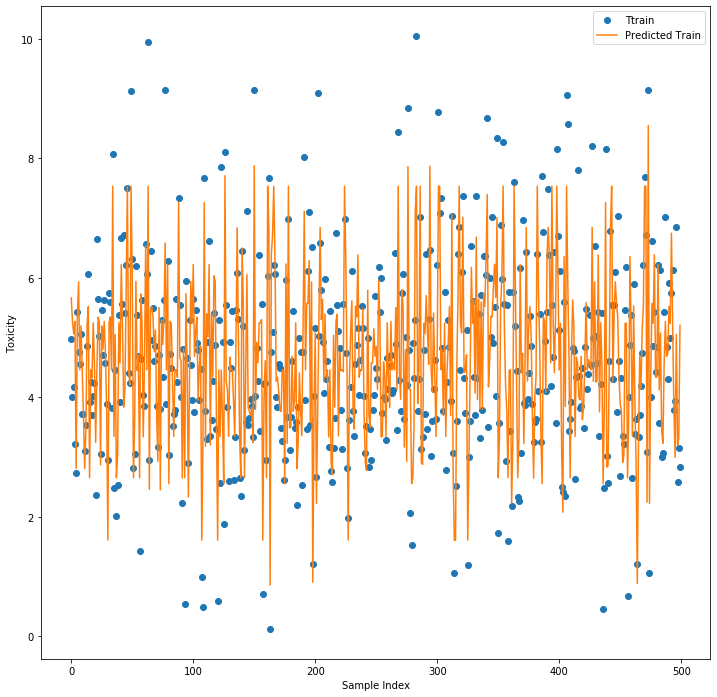

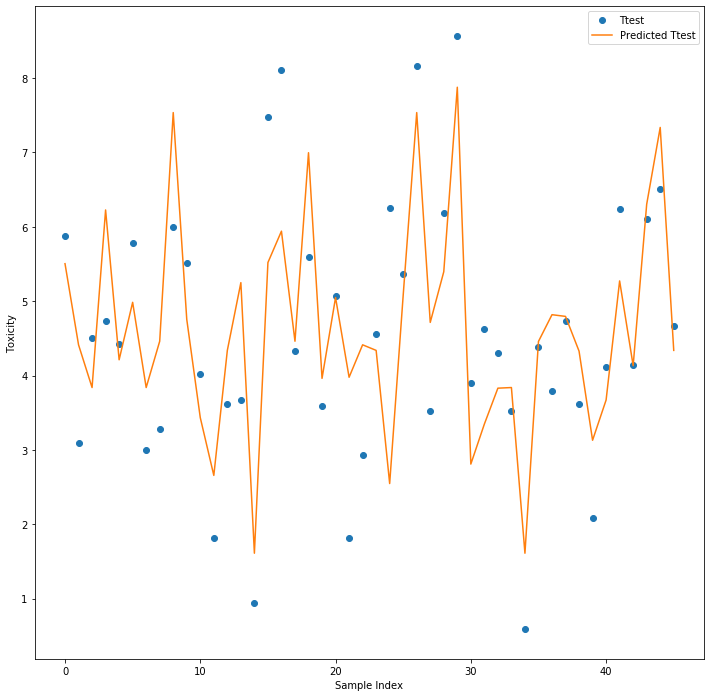

In [83]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is ADAM experiment-C')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 2D

In [84]:
n_hiddens_list=[10,20,30]
n_epochs=20000
learning_rate=0.01
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')

Adam: Epoch 2000 Error=0.24220
Adam: Epoch 4000 Error=0.19448
Adam: Epoch 6000 Error=0.15198
Adam: Epoch 8000 Error=0.11761
Adam: Epoch 10000 Error=0.10593
Adam: Epoch 12000 Error=0.13419
Adam: Epoch 14000 Error=0.09523
Adam: Epoch 16000 Error=0.08577
Adam: Epoch 18000 Error=0.08881
Adam: Epoch 20000 Error=0.09741


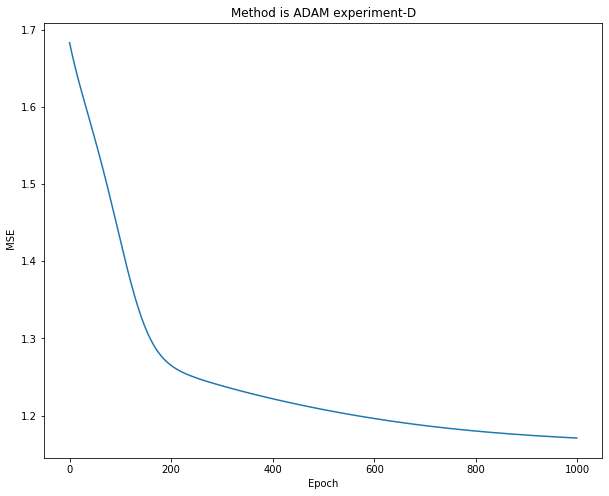

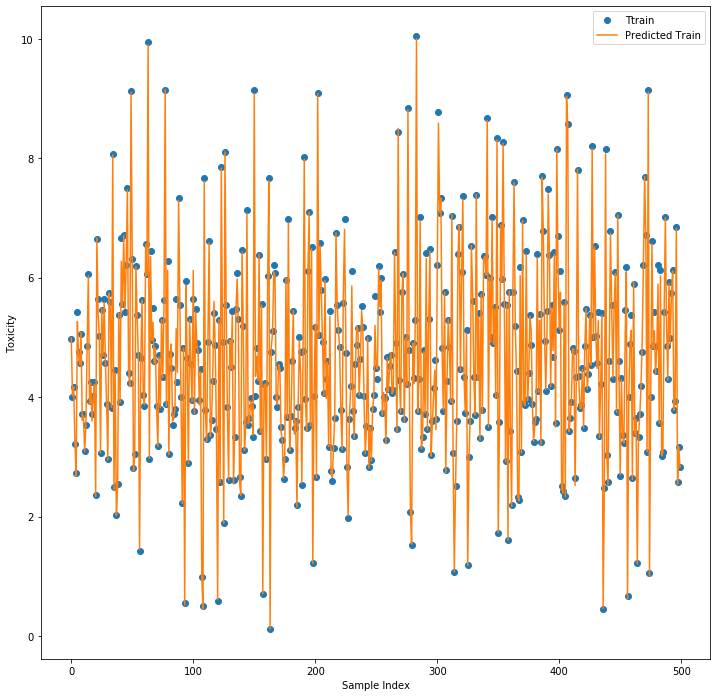

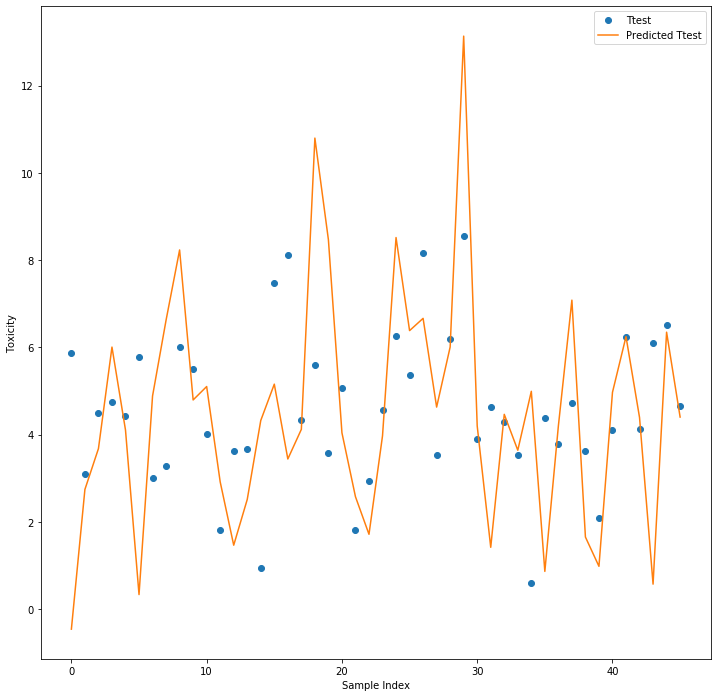

In [85]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is ADAM experiment-D')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 2E

In [86]:
n_hiddens_list=[30,30]
n_epochs=40000
learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')

Adam: Epoch 4000 Error=0.13366
Adam: Epoch 8000 Error=0.13218
Adam: Epoch 12000 Error=0.17316
Adam: Epoch 16000 Error=0.17398
Adam: Epoch 20000 Error=0.18276
Adam: Epoch 24000 Error=0.16708
Adam: Epoch 28000 Error=0.17888
Adam: Epoch 32000 Error=0.14132
Adam: Epoch 36000 Error=0.21349
Adam: Epoch 40000 Error=0.17889


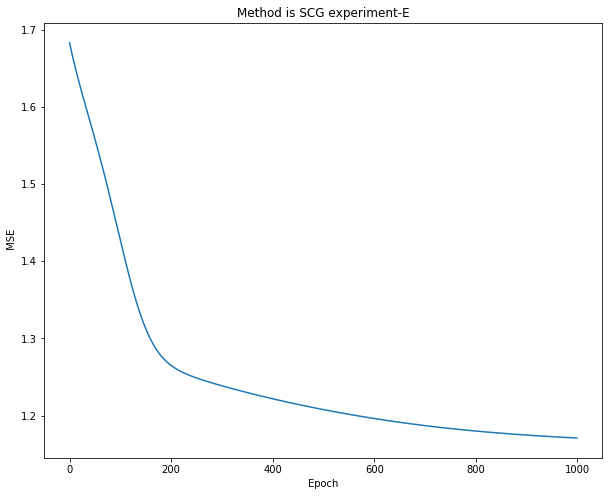

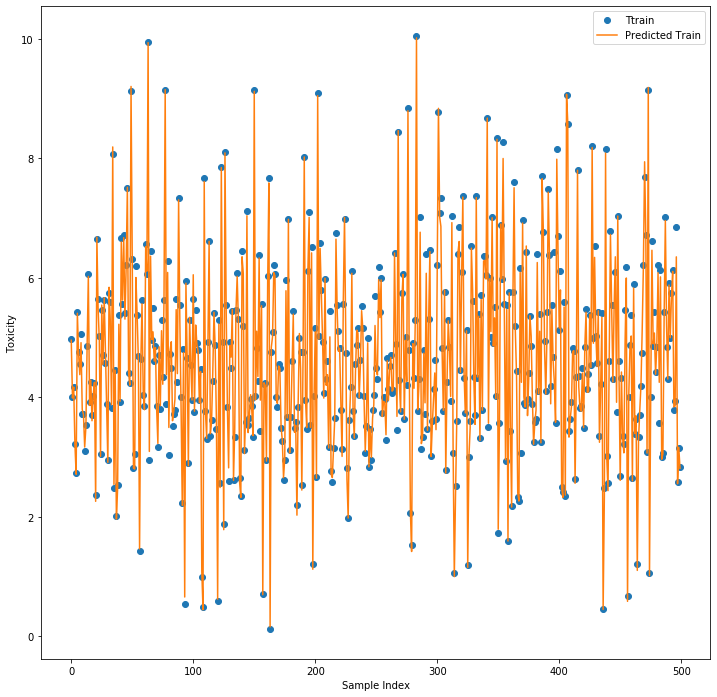

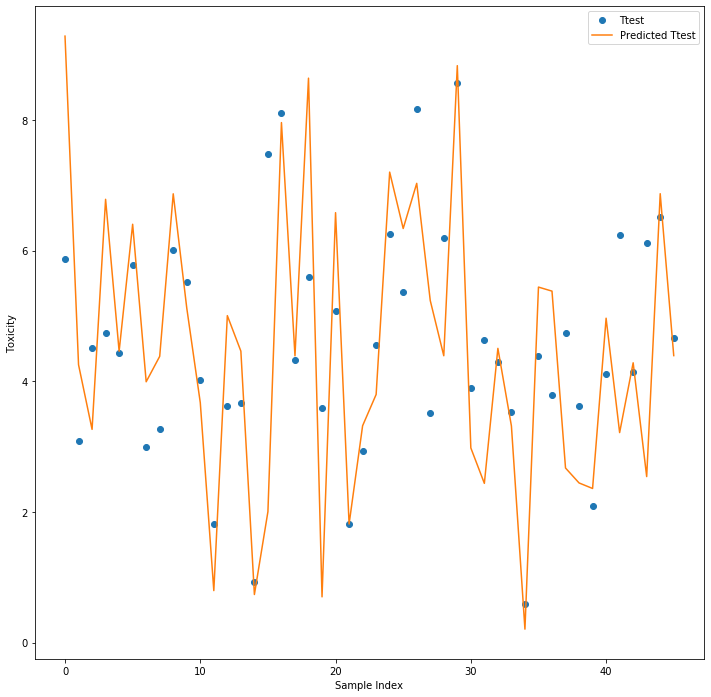

In [87]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SCG experiment-E')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments with SCG

# Experiments 3A

In [88]:
n_hiddens_list=[30,40]
n_epochs=1000

n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='scg')

SCG: Epoch 100 Error=0.75349
SCG: Epoch 200 Error=0.51129
SCG: Epoch 300 Error=0.39129
SCG: Epoch 400 Error=0.33176
SCG: Epoch 500 Error=0.28383
SCG: Epoch 600 Error=0.24371
SCG: Epoch 700 Error=0.21684
SCG: Epoch 800 Error=0.19909
SCG: Epoch 900 Error=0.18315
SCG: Epoch 1000 Error=0.16925


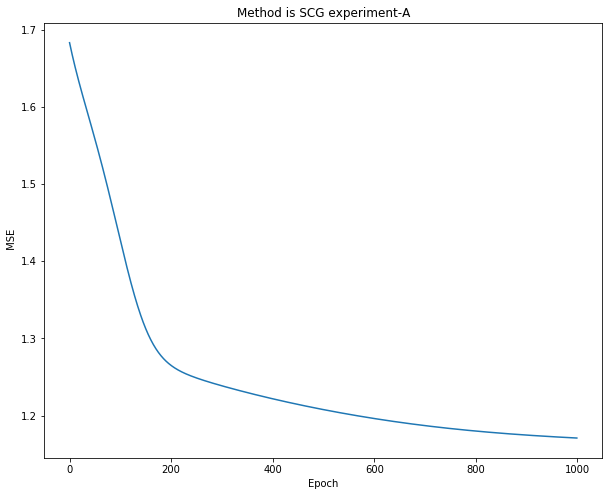

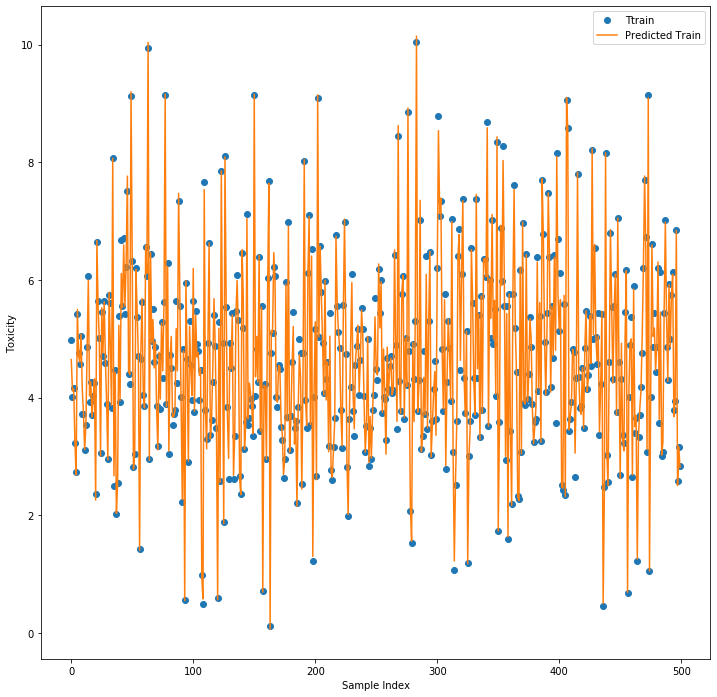

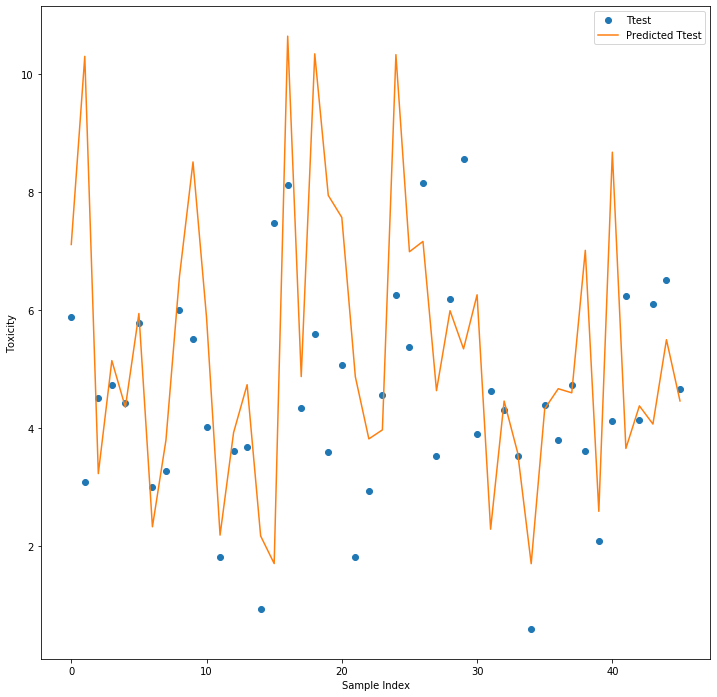

In [89]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SCG experiment-A')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 3B

In [90]:
n_hiddens_list=[10,10]
n_epochs=1000
#learning_rate=0.01
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet1 = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet1.train(Xtrain, Ttrain, n_epochs, learning_rate, method='scg')

SCG: Epoch 100 Error=0.87259
SCG: Epoch 200 Error=0.68797
SCG: Epoch 300 Error=0.56490
SCG: Epoch 400 Error=0.51381
SCG: Epoch 500 Error=0.48287
SCG: Epoch 600 Error=0.47204
SCG: Epoch 700 Error=0.46284
SCG: Epoch 800 Error=0.45372
SCG: Epoch 900 Error=0.44300
SCG: Epoch 1000 Error=0.43933


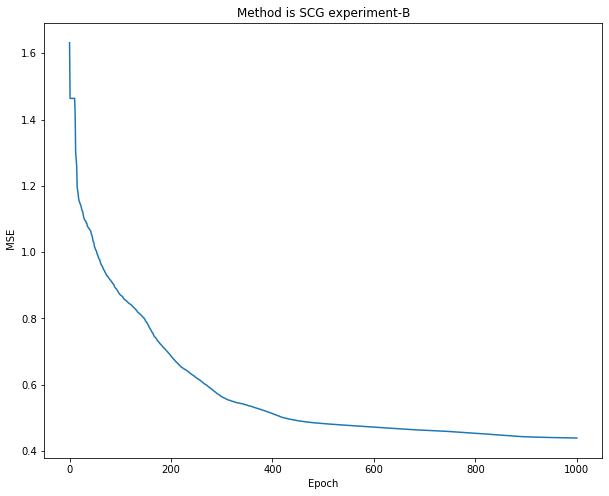

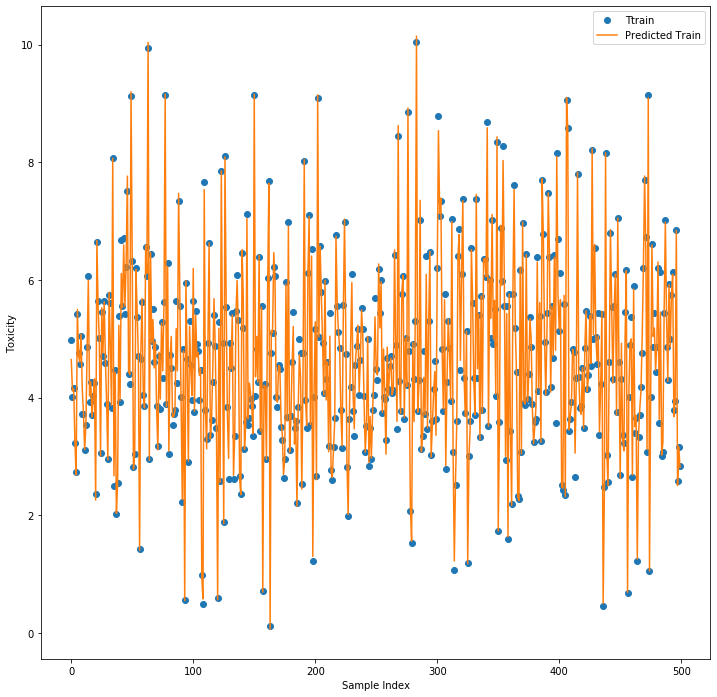

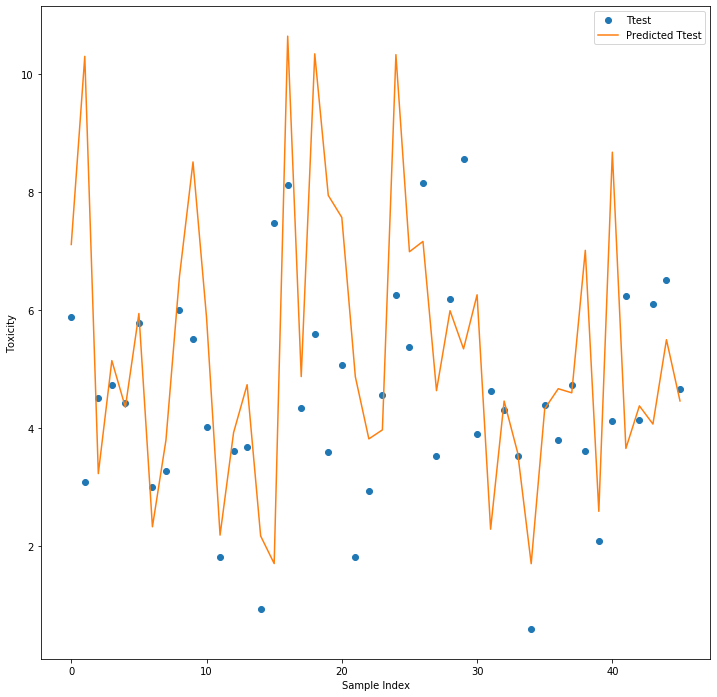

In [91]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SCG experiment-B')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 3C

In [92]:
n_hiddens_list=[10,20,30]
n_epochs=20000
#learning_rate=0.1
n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='scg')

SCG: Epoch 2000 Error=0.14188
SCG: Epoch 4000 Error=0.10163
SCG: Epoch 6000 Error=0.08790
SCG: Epoch 8000 Error=0.07667
SCG: Epoch 10000 Error=0.06772
SCG: Epoch 12000 Error=0.06316
SCG: Epoch 14000 Error=0.06075
SCG: Epoch 16000 Error=0.05939
SCG: Epoch 18000 Error=0.05832
SCG: Epoch 20000 Error=0.05757


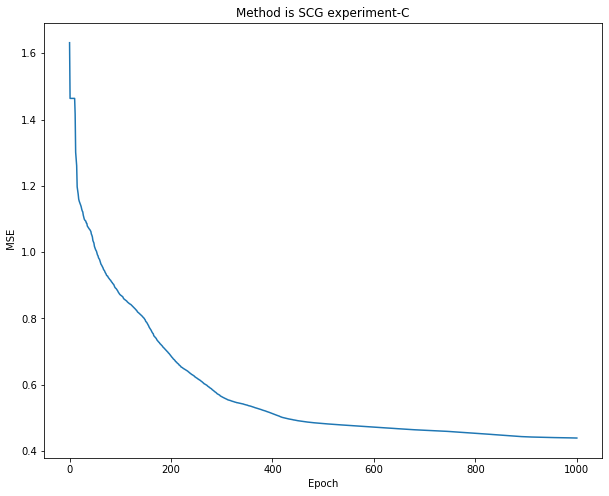

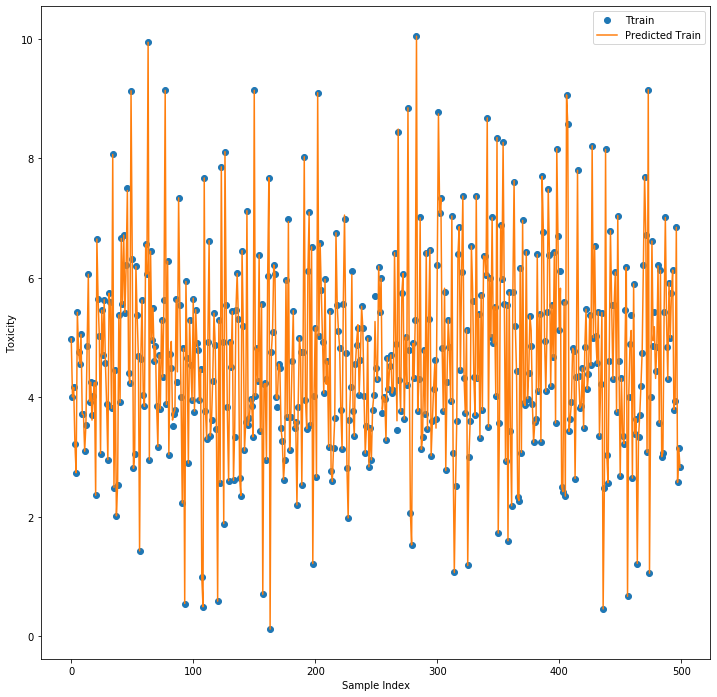

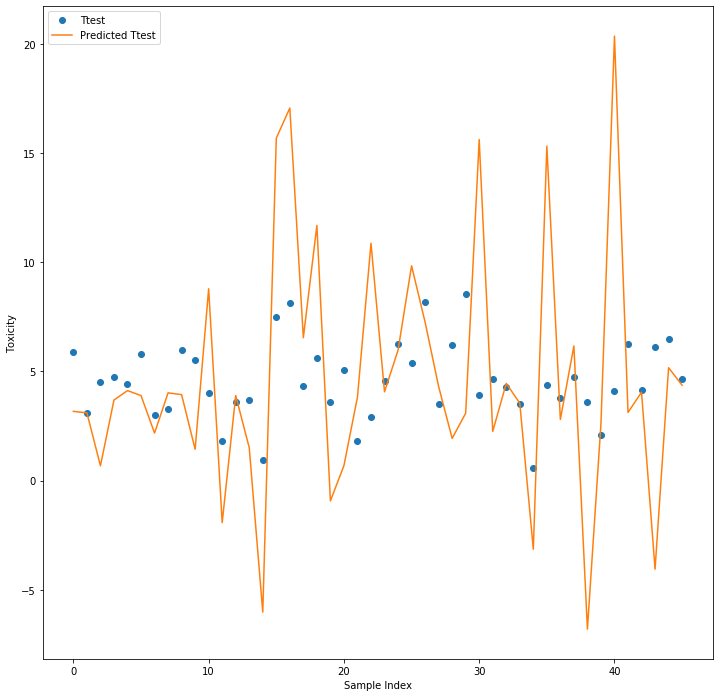

In [93]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SCG experiment-C')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# Experiments 3D

In [94]:
n_hiddens_list=[10,30]
n_epochs=10000

n_inputs=Xtrain.shape[1]
n_outputs=Ttrain.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='scg')

SCG: Epoch 1000 Error=0.29856
SCG: Epoch 2000 Error=0.23295
SCG: Epoch 3000 Error=0.20151
SCG: Epoch 4000 Error=0.18932
SCG: Epoch 5000 Error=0.18018
SCG: Epoch 6000 Error=0.17301
SCG: Epoch 7000 Error=0.16847
SCG: Epoch 8000 Error=0.16386
SCG: Epoch 9000 Error=0.15988
SCG: Epoch 10000 Error=0.15683


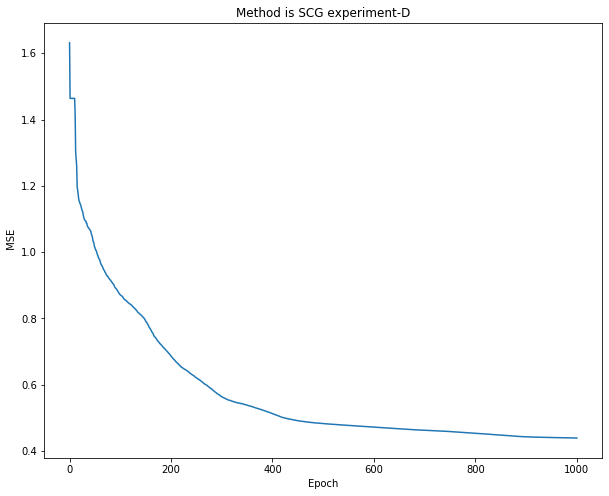

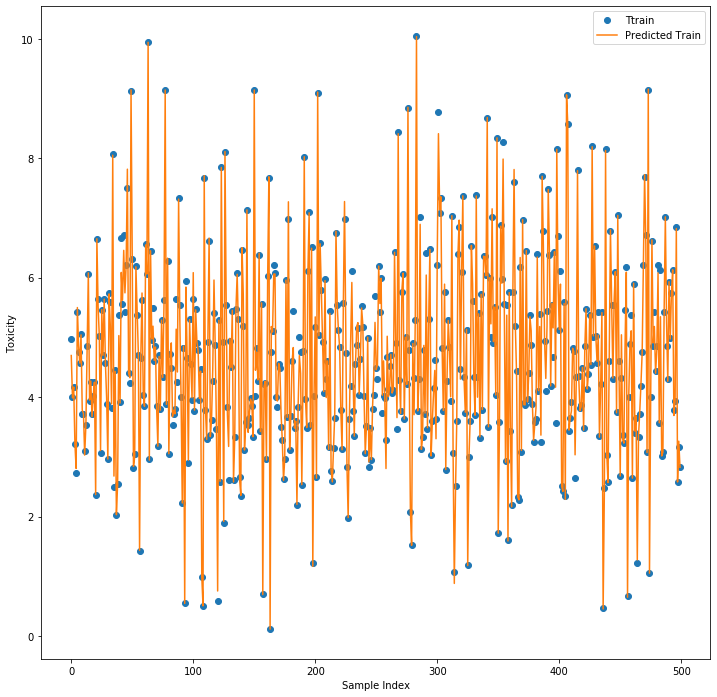

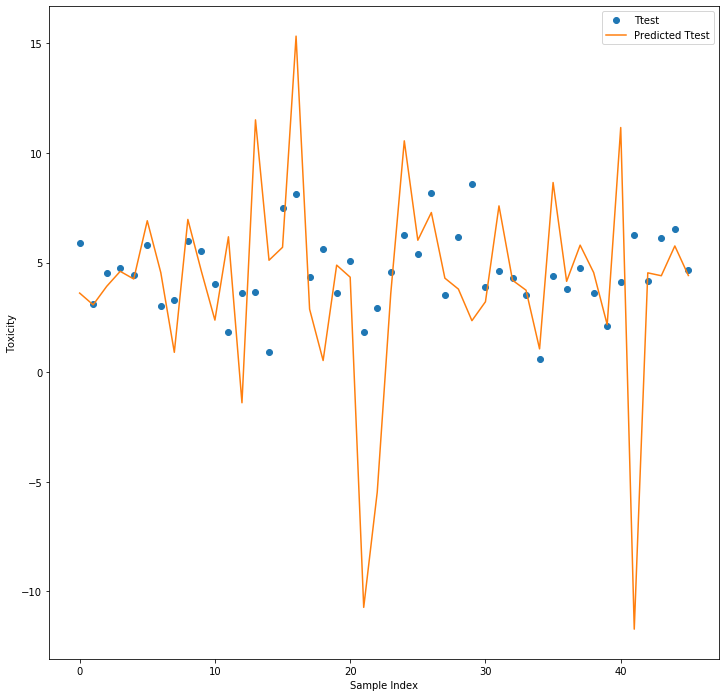

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(nnet1.error_trace)
plt.xlabel('Epoch')
plt.ylabel(' MSE')
plt.title('Method is SCG experiment-D')

plt.figure(figsize=(12, 12))
Ytrain = nnet.use(Xtrain)
plt.plot(Ttrain, 'o',label='Ttrain')
plt.plot(Ytrain,label='Predicted Train')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

plt.figure(figsize=(12, 12))
Ytest = nnet.use(Xtest)
plt.plot(Ttest, 'o',label='Ttest')
plt.plot(Ytest,label='Predicted Ttest')
plt.xlabel('Sample Index')
plt.ylabel('Toxicity')
plt.legend()

# observations:


I have done different kind of observations by changing the parameters for the model and with 3 different optimizer functions SGD, ADAM and SCG.I have SGD as 1, ADAM as 2 and SCG as 3 .named experiments under each optimizer as 1A ,2C etc.
For SGD:
n_hiddens_list=[20,20] 
n_epochs=2000
learning_rate=0.01  these are basic my configuration in 1A. I got an error of 1.15 . It is relatively not optimised network so
i have increased the network to 3 layers in 1B and learning rate is 0.1 and i got error in 0.25. which is relatively good.
so i tried with same configuration and still decreasing the learning to 0.01 but the error roses to very high to 1.15. It is aclear indication that even though similar network with SGD the reduced learning rate is not a good option. For 1D I have changed the network back to 2 layers [30,30] and epochs =40000 increased learning rate back to 0.1. This configuration is the best among the all for SGD with lowest error value= 0.19. I have tried similar network with more neurons in 1E [50,50] keeping remaining  parameters same but the error is decreased to 0.20 but it is not the optimised one.



ADAM:
   I have done  5 experiments with ADAM. first with basic structure of 2 layers [20,20] epochs=2000, learning rate=0.01 . the rmse value is 0.22 which is really good for a simple network structure compared to SGD. so i have tried to find out the more simple network if it can still produce good results so i have reduced the network structure to [10,10] epochs =1000 and learning rate as same before. But rmse is 0.56 . so the network is not best compared to first one.I have made a 3 hidden layer network in experiment 2C with 20000 epochs and learning rate=0.1 the error is 0.98. still not a good configuration. Now keeping all parameters same as before just reducing the learning rate to 0.1 in Experiment 2D i run the experiment . The rmse values at best for adam with value 0.09. this states that reduced learning rate for a larger network is best for adam compared to SGD. I have run another experiment with configurations [30 30] epochs=40000 learning rate =0.1 and rmse is still good at 0.17 for 2E. This experiment suggest that if we increse learning and epochs  network with less layers is also behaving good. 

SCG:For SCG i have done 4 experiments.3A is with [30,40] epochs=1000 and the rmse is 0.16 which is relatively better than other optimizers with similar network structure. In 3B i tried  reducing the neirons to [10,10] and same epochs. but rmse increased to 0.43.  For Experiment 3C  i have increased the layers to [10,20,30] with larger epochs=20000  and the rmse is at best with 0.05 the best among all oof the above configurations.the model is perfectly fitting to the data.By continous changing the parameters I have tried another network to [10,30] epochs=10000 and rmse reduced to 0.15 which is at probably close to the best configuration . so from the last experiments increased number of epochs does favour the optimised network in SCG.

Conclusion:
From the above experiments:
For SGD:1D is the best network with RMSE: 0.19
For ADAM:2D is the best network with RMSE: 0.09
FOr SCG: 3C is the best network with RMSE:0.05

Overall SCG is the best optimizer to update the weights close to the data and the configuration for the given QSAR data set is
[10,20,30] epochs=20000 RMSE of 0.05.